In [96]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.basemap import Basemap
import h5py as h5
import os
from scipy.interpolate import UnivariateSpline
from IPython.display import clear_output

In [97]:
# Get SIF shape and wl grid
f = h5.File('/Users/owinton/Documents/TROPOMI/PS_SIF_map.h5','r')
SIF_spec = f['SIF_shape'][:]
SIF_wl = f['wlGrid'][:]
f.close()

### Getting the Principal Components from SVD

####  Get a lot of SIF-free spectra for each detector spatial pixel

In [100]:
# Get 150 spectra for each pixel (footprint, one pixel in swath)
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/'
nspec = 150
spec_pixel_all = np.zeros((408, 150, 497))
wl_pixel_all = np.zeros((408, 497))
count = np.zeros((408))
samplelat = np.zeros((408, 150))
samplelon = np.zeros((408, 150))

# Check each file
for filename in os.listdir(directory):
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        #print(file_nadir)
        fn = h5.File(file_nadir)
        lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
        lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
        sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
        wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,:,:]
        spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,:,:]
        fn.close()
        
        # For each pixel (get rid of 20 edge pixels on each side)
        for i in range(408):
            # wl_grid is defined within the pixel
            wl_pixel_all[i, :] = wl_spec[i+20, :]
            # Check each swath
            for j in range(np.shape(lat)[0]):
                # Find spectra in Sahara, until 150 spectra are obtained
                if (lat[j, i+20] > 18 and lat[j,i+20] < 28 and lon[j,i+20] > -8 and lon[j,i+20] < 28 and sza[j, i+20] < 60 and count[i] < 150):
                    spec_pixel_all[i, int(count[i]), :] = spec[j, i+20, :]
                    samplelat[i, int(count[i])] = lat[j,i+20]
                    samplelon[i, int(count[i])] = lon[j,i+20]
                    count[i] += 1
                    
                    # Give progress info
                    clear_output(wait=True)
                    print("Current progress",i, "pixels done")
                    


Current progress 407  spectra


Text(0.5,1,'Solar spectrum sample area')

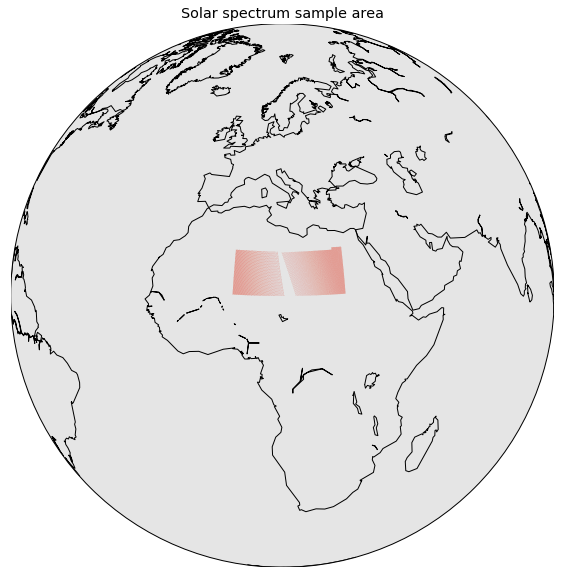

In [14]:
# Plot the solar spectrum sample area
m = Basemap(projection='ortho', lon_0=14, lat_0=18, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, 0.0001, marker='D', latlon=True)
m.drawcoastlines()
plt.title('Solar spectrum sample area')

In [112]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. 
# Fixed amount of spectral values in each pixel to make matrices easier
spec_pixel_trunc = np.zeros((408, 150, 122))
wl_pixel_trunc = np.zeros((408, 122))
for i in range(408):
    index_pixel = wl_pixel_all[i, :] > 743
    wl_pixel = wl_pixel_all[i, index_pixel]
    wl_pixel_trunc[i, :] = wl_pixel[:122]
    for j in range(150):
        spec_pixel = spec_pixel_all[i, j, index_pixel]
        spec_pixel_trunc[i, j, :] = spec_pixel[:122]
wl_spec = wl_pixel_trunc
spec = spec_pixel_trunc

### Do the SVD and show some of the PC-functions and their explained variance

In [113]:
u = np.zeros((408, 150, 150))
s = np.zeros((408, 122))
vh = np.zeros((408, 122, 122))
for i in range(408):
    u[i,:,:], s[i,:], vh[i,:,:] = np.linalg.svd(spec[i, :, :])
    # For each pixel, the rows (vh is v transposed) are the eigen vectors;
    # Use the first 5 as principal components for SIF-free spectra i.e. 'pure' reflected solar spectrum

[1.27592984e-04 2.42058642e-07 5.64126819e-08 3.99434892e-08
 1.41382664e-08]


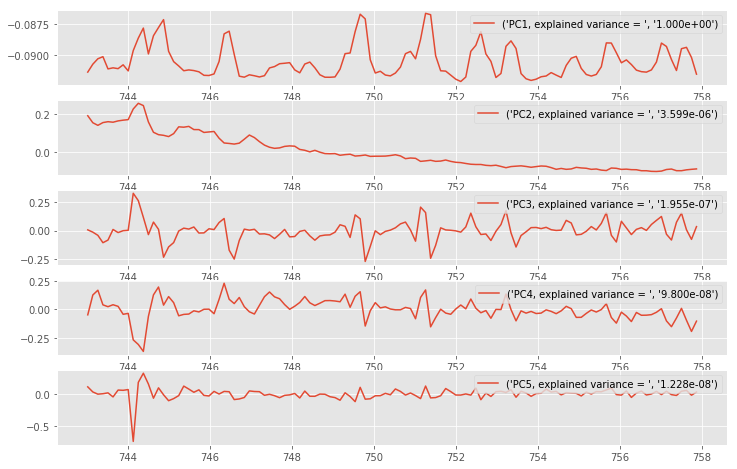

In [114]:
# Showing the Principal component functions, along with their explained variance 
# (defined correctly? Only takes into account the relative value of singualr values)
figsize(12,8)
plt.subplot(511)
test_pixel = 1
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,0,:],label=('PC1, explained variance = ', '{:0.3e}'.format(s[test_pixel,0]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(512)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,1,:],label=('PC2, explained variance = ', '{:0.3e}'.format(s[test_pixel,1]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(513)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,2,:],label=('PC3, explained variance = ', '{:0.3e}'.format(s[test_pixel,2]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(514)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,3,:],label=('PC4, explained variance = ', '{:0.3e}'.format(s[test_pixel,3]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(515)
plt.plot(wl_pixel_trunc[test_pixel,:],vh[test_pixel,4,:],label=('PC5, explained variance = ', '{:0.3e}'.format(s[test_pixel,4]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)

print(s[test_pixel,0:5])


### Forward model with Jacobian

In [104]:
# Forward model defined based upon Köhler (2018) supplement eq. 1
def ForwardModel(x, PC, wl_grid, SIF, compK = False):
    # Unnecessary, but makes comparison to Köhler easier
    gam1, gam2, gam3, gam4, gam5 = x[0], x[1], x[2], x[3], x[4]
    eta1, eta2, eta3 = x[5], x[6], x[7]
    Fs = x[8]
    P1 = wl_grid
    P2 = 1/2*(3*wl_grid**2-1)
    P3 = 1/2*(5*wl_grid**3-3*wl_grid)
    
    sun = gam1 * PC[0] + gam2 * PC[1] + gam3 * PC[2] + gam4 * PC[3] + gam5 * PC[4]
    leg = eta1 * P1 * PC[0] + eta2 * P2 * PC[0] + eta3 * P3 * PC[0]
    sif = Fs * SIF
    
    Ftoa = sun + leg + sif
    if compK == True:
        K = np.zeros((122, 9))
        K[:, 0] = PC[0, :]
        K[:, 1]= PC[1, :]
        K[:, 2] = PC[2, :]
        K[:, 3] = PC[3, :]
        K[:, 4] = PC[4, :]
        K[:, 5] = P1*PC[0, :]
        K[:, 6] = P2*PC[0, :]
        K[:, 7] = P3*PC[0, :]
        K[:, 8] = SIF
        return Ftoa, K
    else:
        return Ftoa
    

### Testing retrieval on Sahara pixels

In [117]:
#
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Factor for weighing the singular value of PC1:5 in terms of variance. 
factor = 1
    #spectra #pixels #elements
xhat = np.zeros((150, 408, 9))
                #spectra #pixels #wl
residuals = np.zeros((150, 408, 122))
            #elements
# Prior to constrain higher order Principal components to a mean of 0.
# Here all state vector elements are given a mean of 0, 
# The amount of constraint is then defined in the variance in Sa
xa = np.zeros((9,))
for pixel in range(408):
    # Singular values for this pixel
    sv = s[pixel,0:5]
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    # The Principal component
    PC = vh[pixel, 0:5, :]
    # The wl_grid and SIF for this pixel
    wl_grid = wl_spec[pixel, :]
    SIF = spl(wl_grid)
    # Get the Jacobian
    F, K = ForwardModel(np.zeros(9), PC, wl_grid, SIF, True)
    for swath in range(150):
        spec_it = spec[pixel, swath]
        # Noise model
        noise = 0.06475 + 0.03721 * np.sqrt(spec_it)
        invSe = np.diag(1/noise**2)
        # Linear retrieval with prior
        xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
        # Save the residuals
        residuals[swath, pixel, :] = spec_it - ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF)
    
    # Progress info
    clear_output(wait=True)
    print("Current progress",np.round((pixel/408) * 100, 1), "%")
        

Current progress 99.8 %


Text(0.5,1,'SIF retrievals')

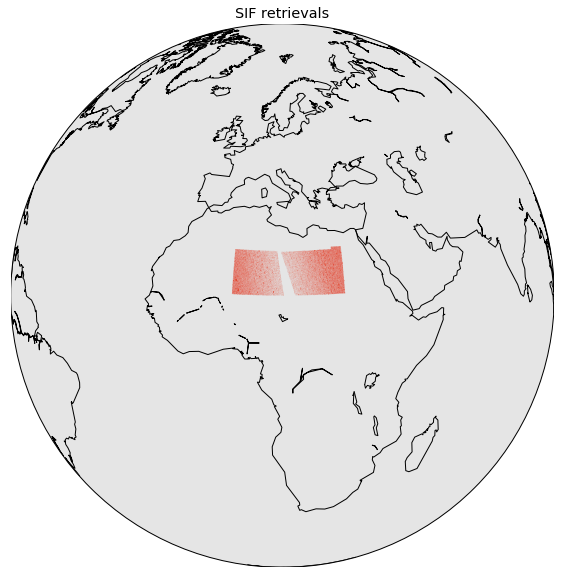

In [118]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='ortho', lon_0=14, lat_0=18, resolution='c')
figsize(16,10)
# I don't know how to show ungridded data best, scatter does not handle negative radii well
m.scatter(samplelon, samplelat, 1e14*SIF_retrievals**2, marker='D', latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')

### Problematic residuals! Similar shape, all offset from 0

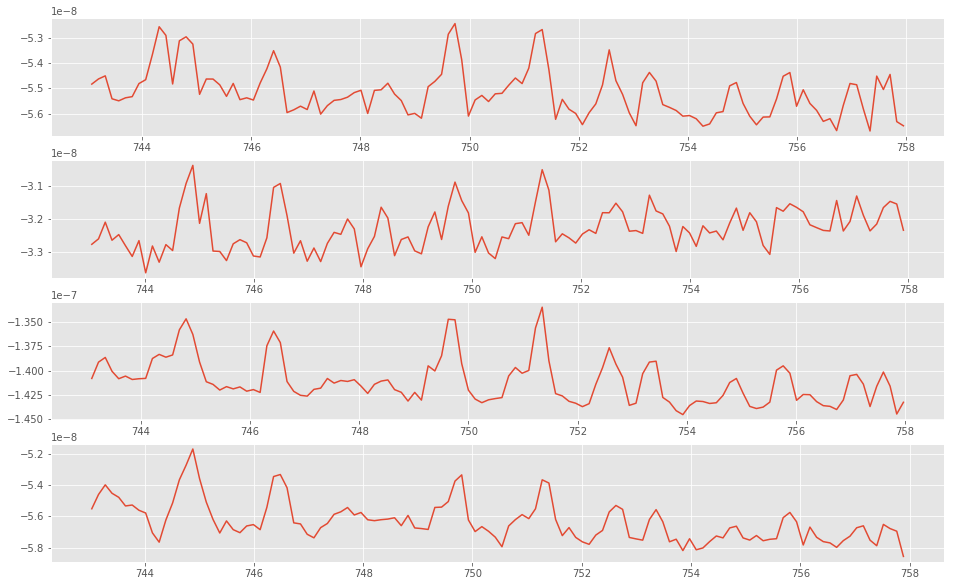

In [125]:
plt.subplot(411)
plt.plot(wl_spec[100,:],residuals[0, 100, :])
plt.subplot(412)
plt.plot(wl_spec[200,:],residuals[50, 200, :])
plt.subplot(413)
plt.plot(wl_spec[300,:],residuals[100, 300, :])
plt.subplot(414)
plt.plot(wl_spec[400,:],residuals[149, 400, :])

### Retrieval of one file at a time

In [33]:
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA'
filename = 'S5P_OFFL_L1B_RA_BD6_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip'
file_nadir = os.path.join(directory, filename)
fn = h5.File(file_nadir)
lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
fn.close()

#### Why are there negative irradiances?

In [34]:
sum(sum(sum((spec<0))))/sum(sum(sum((spec>0))))

0.02082479534336627

In [35]:
print(lat.shape, lon.shape, sza.shape, wl_spec.shape, spec.shape)

(3245, 408) (3245, 408) (3245, 408) (408, 497) (3245, 408, 497)


In [36]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. Same amount of spectral values to make matrices easier
# Get rid of 20 pixels at each edge as well
spec_pixel_trunc = np.zeros((lat.shape[0], 408, 122))
wl_pixel_trunc = np.zeros((408, 122))
for i in range(408):
    index_pixel = wl_spec[i, :] > 743
    wl_pixel = wl_spec[i, index_pixel]
    wl_pixel_trunc[i, :] = wl_pixel[:122]
    for j in range(lat.shape[0]):
        spec_pixel = spec[j, i, index_pixel]
        spec_pixel_trunc[j, i, :] = spec_pixel[:122]
wl_spec = wl_pixel_trunc
spec = spec_pixel_trunc

In [88]:
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Factor for weighing the singular value of PC1:4 in terms of variance
factor = 1e-5
                     #swaths        #pixels #state vector elements
xhat = np.zeros((lat.shape[0], lat.shape[1], 9))
residuals = np.zeros((lat.shape[0], lat.shape[1], 122))
# Prior
xa = np.zeros((9,))
# For each pixel
for pixel in range(408):
    # Singular values for this pixel
    sv = s[pixel,0:5]
    # Prior for this pixel
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    # Principal component functions for this pixel
    PC = vh[pixel, 0:6, :]
    # Wavelength grid for this pixel
    wl_grid = wl_spec[pixel, :]
    # SIF-shape interpolated to wavelength grid of this pixel
    SIF = spl(wl_grid)
    # Get the Jacobian K
    F, K = ForwardModel(np.zeros(9), PC, wl_grid, SIF, True)
    for swath in range(1000, 1500):#(lat.shape[0]):
        if (spec[swath, pixel, :]<0).any():
            continue
        noise = 0.06475 + 0.03721 * np.sqrt(spec[swath, pixel, :])
        invSe = np.diag(1/noise**2)
        spec_it = spec[swath, pixel, :]
        xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
        residuals[swath, pixel, :] = spec_it - ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF)
    clear_output(wait=True)
    print("Current progress",np.round((pixel/408) * 100, 1), "%")

   

Current progress 99.8 %


In [89]:
xhat[1000, 100, :]

array([-1.80792809e-02,  6.93373295e-19,  5.83765140e-19, -7.70487204e-20,
       -1.26506418e-19,  7.15730712e-05, -6.30134309e-08,  1.66451297e-11,
        5.83247584e-09])

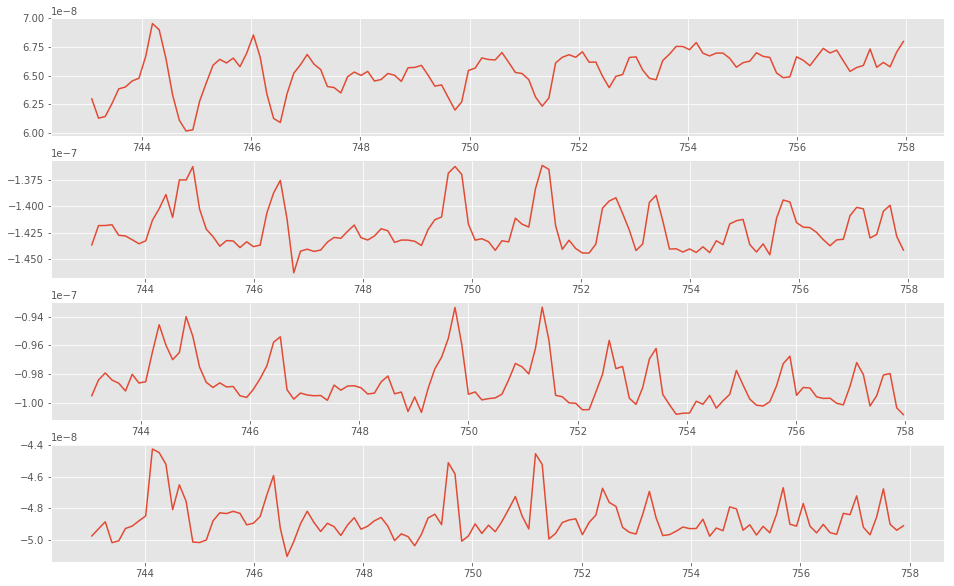

In [92]:
plt.subplot(411)
plt.plot(wl_spec[100,:],residuals[1000, 100, :])
plt.subplot(412)
plt.plot(wl_spec[200,:],residuals[1100, 200, :])
plt.subplot(413)
plt.plot(wl_spec[300,:],residuals[1200, 300, :])
plt.subplot(414)
plt.plot(wl_spec[400,:],residuals[1300, 400, :])

In [68]:
xhat[swath,pixel,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5,1,'SIF retrievals')

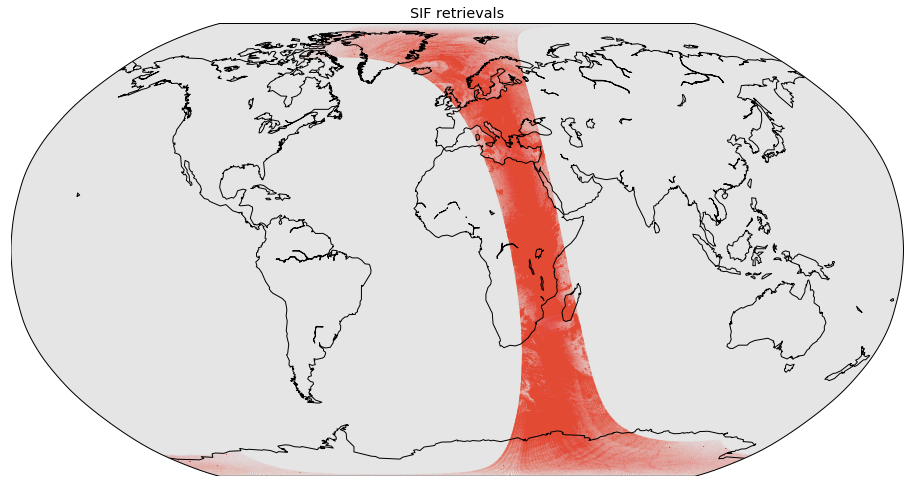

In [69]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[:, :], lat[:, :], 1e14*SIF_retrievals**2, latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')
